# Tiny example
Uses methods in torch_nvd to
1. Generate a chain graph of length 2
2. Generate a tensor from the graph
3. Compute the Linv matrix
4. Compute the ideological distance
5. Compute the ideological manifold

- Opinion vectors are orthogonal, and another orthogonal opinion vector is added (e.g. 2→3)
- Opinion vectors are duplicated (e.g. 2→4)

In [1]:

"""
Uses methods in torch_nvd to
1. Generate a chain graph of length 2
2. Generate a tensor from the graph
3. Compute the Linv matrix
4. Compute the ideological distance
5. Compute the ideological manifold

- Opinion vectors are orthogonal, and another orthogonal opinion vector is added (e.g. 2→3)
- Opinion vectors are duplicated (e.g. 2→4)
""";

In [2]:
# import sys
# sys.path.append('..')

import tests.methods.torch_nvd as nvd
import tests.methods.utils as utils

import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import numpy as np
import pandas as pd
import networkx as nx

import random

from scipy.stats import pearsonr
import torch
import torch_geometric

In [3]:
n_comms = 2 # number of communities
nodes_per_comm = 5 # number of nodes per community
intercon = 1
p_out = 1  # p_out
shift = 1

p = utils.ideo_make_p(p_out, n_comms, intercon)
p

array([[0, 1],
       [1, 0]])

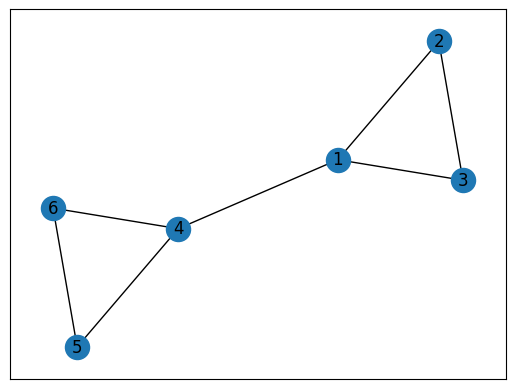

In [4]:
num_opinions = 6

# Generating G with SBM
p = utils.ideo_make_p(n_comms=2, p_out=0.1, intercon=1)
G = utils.ideo_make_G(p=p, n_comms=2, nodes_per_comm=num_opinions//2)

# if G has one less node than num_opinions, add a node and connect it to the first node
if len(G) < num_opinions:
    G.add_node(len(G))
    G.add_edge(0, len(G)-1)

# if G is disconnected, connect the two components
if not nx.is_connected(G):
    # find the two components
    components = list(nx.connected_components(G))
    # connect them
    G.add_edge(list(components[0])[0], list(components[1])[0])

nx.draw_networkx(G)

## Effect of adding orthogonal opinions

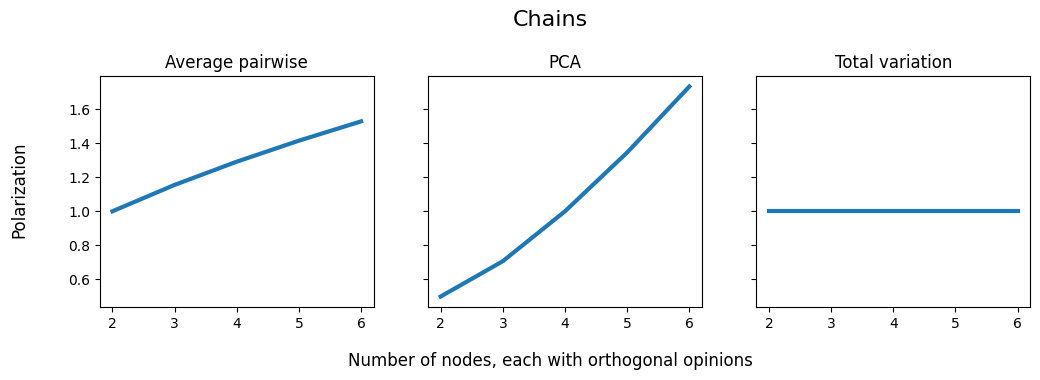

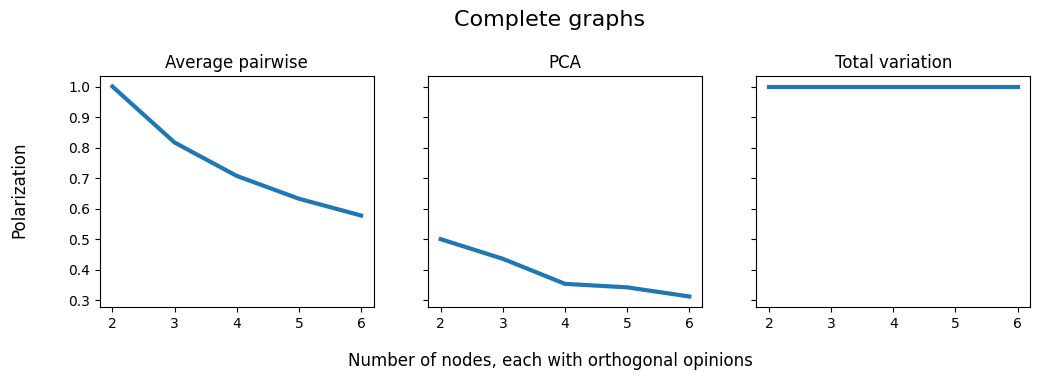

In [5]:
num_opinions_range = range(2, 7)
polarization_metrics = [nvd.ideological, nvd.ideological_manifold, nvd.total_variation]
metric_names = ['Average pairwise', 'PCA', 'Total variation']

for graph_name, graph_type in [('Chains', nx.path_graph), 
                               ('Complete graphs', nx.complete_graph)]:
    fig, ax = plt.subplots(1, len(polarization_metrics), figsize=(4*len(polarization_metrics), 3), sharey=True)
    for i, (metric_name, polarization_metric) in enumerate(zip(metric_names, polarization_metrics)):
        polarizations = []
        for num_opinions in num_opinions_range:
            G = graph_type(num_opinions)
            o = pd.DataFrame(columns=['o'+str(i) for i in range(num_opinions)], data=np.identity(num_opinions))
            tensor = nvd.make_tensor(G, o)
            Linv = nvd._Linv(tensor)

            polarization = polarization_metric(tensor, Linv = Linv)
            polarizations.append(polarization)
        ax[i].plot(num_opinions_range, polarizations, lw=3)
        ax[i].set_title(metric_name)
    fig.supxlabel('Number of nodes, each with orthogonal opinions', y=-0.1)
    fig.supylabel('Polarization', x=0.05)
    fig.suptitle(graph_name, y=1.1, fontsize=16)

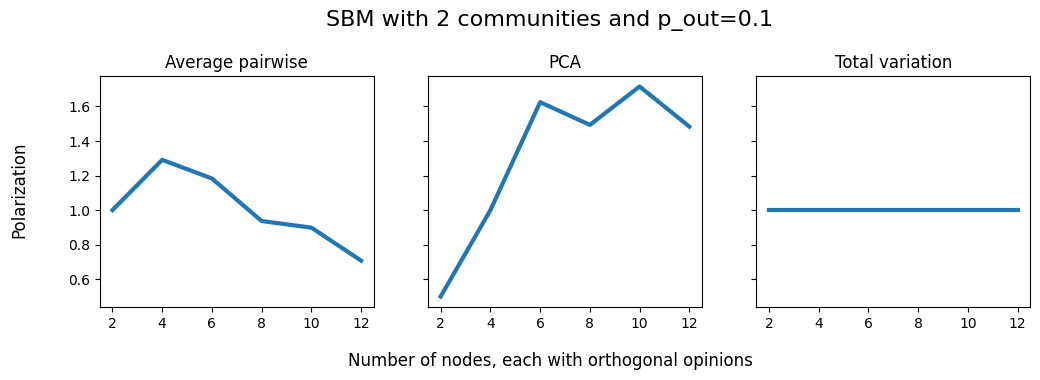

In [6]:
num_opinions_range = range(2, 13, 2)
polarization_metrics = [nvd.ideological, nvd.ideological_manifold, nvd.total_variation]
metric_names = ['Average pairwise', 'PCA', 'Total variation']

fig, ax = plt.subplots(1, len(polarization_metrics), figsize=(4*len(polarization_metrics), 3), sharey=True)
for i, (metric_name, polarization_metric) in enumerate(zip(metric_names, polarization_metrics)):
    polarizations = []
    for num_opinions in num_opinions_range:

        # Generating G with SBM
        p = utils.ideo_make_p(n_comms=2, p_out=0.1, intercon=1)
        G = utils.ideo_make_G(p=p, n_comms=2, nodes_per_comm=num_opinions//2)

        assert len(G) == num_opinions, f'len(G)={len(G)}; num_opinions={num_opinions}'

        # if G is disconnected, connect all components
        if not nx.is_connected(G):
            components = list(nx.connected_components(G))
            for x in range(len(components)-1):
                G.add_edge(random.choice(list(components[x])), random.choice(list(components[x+1])))

        assert nx.is_connected(G)

        o = pd.DataFrame(columns=['o'+str(i) for i in range(num_opinions)], data=np.identity(num_opinions))
        tensor = nvd.make_tensor(G, o)
        Linv = nvd._Linv(tensor)

        # discard first row and column of Linv if num_opinions is even
        if num_opinions % 2 == 0:
            Linv = Linv[1:, 1:]

        polarization = polarization_metric(tensor, Linv=Linv)
        polarizations.append(polarization)

    ax[i].plot(num_opinions_range, polarizations, lw=3)
    ax[i].set_title(metric_name)
fig.supxlabel('Number of nodes, each with orthogonal opinions', y=-0.1)
fig.supylabel('Polarization', x=0.05)
fig.suptitle('SBM with 2 communities and p_out=0.1', y=1.1, fontsize=16);

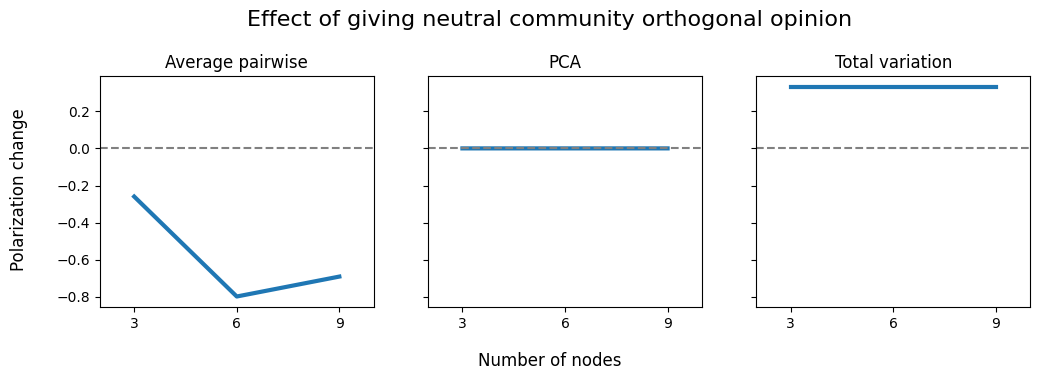

In [8]:
num_nodes_range = range(3, 10, 3)

assert all([num_nodes % 3 == 0 for num_nodes in num_nodes_range]), f'num_nodes not divisible by 3'

polarization_metrics = [nvd.ideological, nvd.ideological_manifold, nvd.total_variation]
metric_names = ['Average pairwise', 'PCA', 'Total variation']
opinion_types = ['neutral', 'third opinion']

fig, ax = plt.subplots(1, len(polarization_metrics), figsize=(4*len(polarization_metrics), 3), sharey=True)

for i, (metric_name, polarization_metric) in enumerate(zip(metric_names, polarization_metrics)):

    differences = []

    for num_nodes in num_nodes_range:


        nodes_per_comm = num_nodes//3
    
        neutral_polarization = 0
        third_polarization = 0
        
        # Generating G with SBM
        p = utils.ideo_make_p(n_comms=3, p_out=0.1, intercon=2)
        G = utils.ideo_make_G(p=p, n_comms=3, nodes_per_comm=nodes_per_comm)
        assert len(G) == num_nodes, f'len(G)={len(G)}; num_nodes={num_nodes}'

        # if G is disconnected, connect all components
        if not nx.is_connected(G):
            components = list(nx.connected_components(G))
            for x in range(len(components)-1):
                G.add_edge(random.choice(list(components[x])), random.choice(list(components[x+1])))
        assert nx.is_connected(G)

        # neutral opinion polarization
        o = pd.DataFrame(columns=['o0', 'o1'], data=np.vstack((np.array([(1,0)]*nodes_per_comm),
                                                            np.array([(0,0)]*nodes_per_comm),
                                                            np.array([(0,1)]*nodes_per_comm))))
        tensor = nvd.make_tensor(G, o)
        Linv = nvd._Linv(tensor)
        Linv = Linv[1:, 1:]  # discard first row and column of Linv
        neutral_polarization = polarization_metric(tensor, Linv=Linv)

        # third opinion polarization
        o = pd.DataFrame(columns=['o0', 'o1', 'o2'], data=np.vstack((np.array([(1,0,0)]*nodes_per_comm),
                                                                    np.array([(0,1,0)]*nodes_per_comm),
                                                                    np.array([(0,0,1)]*nodes_per_comm))))
        tensor = nvd.make_tensor(G, o)
        Linv = nvd._Linv(tensor)
        Linv = Linv[1:, 1:]  # discard first row and column of Linv
        third_polarization = polarization_metric(tensor, Linv=Linv)

        difference = third_polarization - neutral_polarization
        differences.append(difference)

    ax[i].plot(num_nodes_range, differences, lw=3)
    ax[i].set_xticks(num_nodes_range)
    ax[i].set_xlim(num_nodes_range[0]-1, num_nodes_range[-1]+1)
    ax[i].set_title(metric_name)
    ax[i].hlines(0, num_nodes_range[0]-1, xmax=num_nodes_range[-1]+1, colors='gray', linestyles='dashed')

fig.supxlabel('Number of nodes', y=-0.1)
fig.supylabel('Polarization change', x=0.05)
fig.suptitle('Effect of giving neutral community orthogonal opinion', y=1.1, fontsize=16);

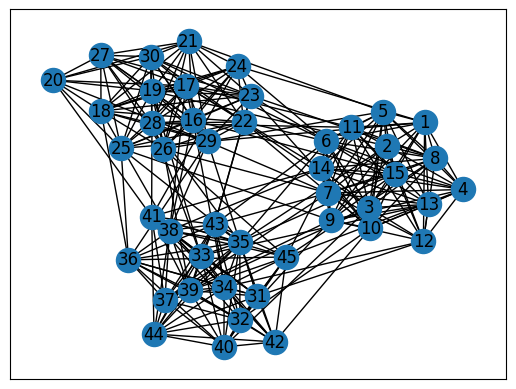

In [9]:
nodes_per_comm = 15
num_nodes = nodes_per_comm*3

p = utils.ideo_make_p(n_comms=3, p_out=0.1, intercon=2)
G = utils.ideo_make_G(p=p, n_comms=3, nodes_per_comm=nodes_per_comm)
assert len(G) == num_nodes, f'len(G)={len(G)}; num_nodes={num_nodes}'

# if G is disconnected, connect all components
if not nx.is_connected(G):
    components = list(nx.connected_components(G))
    for x in range(len(components)-1):
        G.add_edge(random.choice(list(components[x])), random.choice(list(components[x+1])))
assert nx.is_connected(G)

nx.draw_networkx(G)

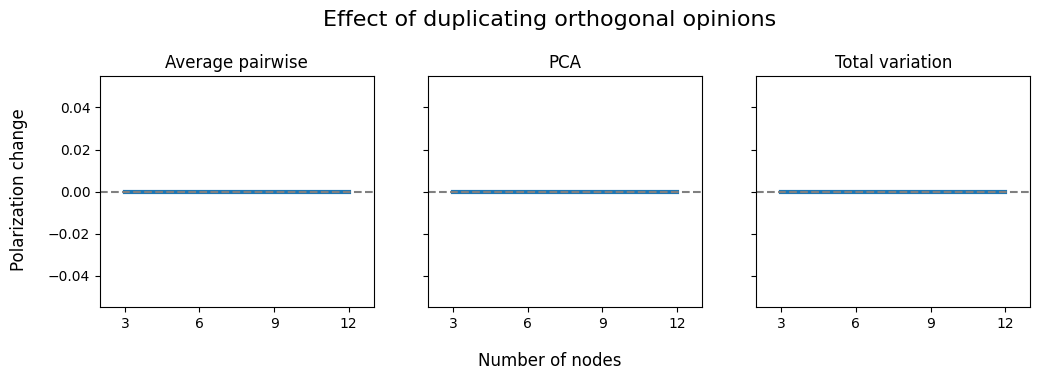

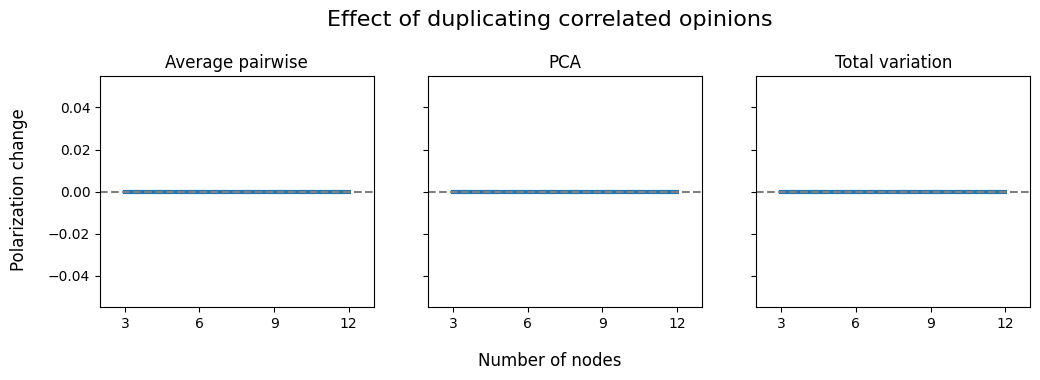

In [10]:
num_nodes_range = range(3, 13, 3)

assert all([num_nodes % 3 == 0 for num_nodes in num_nodes_range]), f'num_nodes not divisible by 3'

polarization_metrics = [nvd.ideological, nvd.ideological_manifold, nvd.total_variation]
metric_names = ['Average pairwise', 'PCA', 'Total variation']
opinion_types = ['orthogonal', 'correlated']

for opinion_type in opinion_types:

    fig, ax = plt.subplots(1, len(polarization_metrics), figsize=(4*len(polarization_metrics), 3), sharey=True)

    for i, (metric_name, polarization_metric) in enumerate(zip(metric_names, polarization_metrics)):

        differences = []

        for num_nodes in num_nodes_range:

            nodes_per_comm = num_nodes//3
        
            unique_polarization = 0
            duplicate_polarization = 0
            
            # Generating G with SBM
            p = utils.ideo_make_p(n_comms=3, p_out=0.1, intercon=2)
            G = utils.ideo_make_G(p=p, n_comms=3, nodes_per_comm=nodes_per_comm)
            assert len(G) == num_nodes, f'len(G)={len(G)}; num_nodes={num_nodes}'

            # if G is disconnected, connect all components
            if not nx.is_connected(G):
                components = list(nx.connected_components(G))
                for x in range(len(components)-1):
                    G.add_edge(random.choice(list(components[x])), random.choice(list(components[x+1])))
            assert nx.is_connected(G)

            # unique opinion polarization
            if opinion_type == 'orthogonal':
                o = pd.DataFrame(columns=['o0', 'o1', 'o2'], data=np.vstack((np.array([(1,0,0)]*nodes_per_comm),
                                                                            np.array([(0,1,0)]*nodes_per_comm),
                                                                            np.array([(0,0,1)]*nodes_per_comm))))
            elif opinion_type == 'correlated':
                o = pd.DataFrame(columns=['o0', 'o1', 'o2'], data=np.vstack((np.array([(1,1,0)]*nodes_per_comm),
                                                                            np.array([(0,1,1)]*nodes_per_comm),
                                                                            np.array([(1,0,1)]*nodes_per_comm))))

            tensor = nvd.make_tensor(G, o)
            Linv = nvd._Linv(tensor)
            Linv = Linv[1:, 1:]  # discard first row and column of Linv
            neutral_polarization = polarization_metric(tensor, Linv=Linv)

            # duplicate opinion polarization
            o = pd.concat([o, o.copy()], axis=1)
            
            tensor = nvd.make_tensor(G, o)
            Linv = nvd._Linv(tensor)
            Linv = Linv[1:, 1:]  # discard first row and column of Linv
            third_polarization = polarization_metric(tensor, Linv=Linv)

            difference = duplicate_polarization - unique_polarization
            differences.append(difference)

        ax[i].plot(num_nodes_range, differences, lw=3)
        ax[i].set_xticks(num_nodes_range)
        ax[i].set_xlim(num_nodes_range[0]-1, num_nodes_range[-1]+1)
        ax[i].set_title(metric_name)
        ax[i].hlines(0, num_nodes_range[0]-1, xmax=num_nodes_range[-1]+1, colors='gray', linestyles='dashed')

    fig.supxlabel('Number of nodes', y=-0.1)
    fig.supylabel('Polarization change', x=0.05)
    fig.suptitle(f'Effect of duplicating {opinion_type} opinions', y=1.1, fontsize=16);